<a href="https://colab.research.google.com/github/pszemraj/vid2cleantxt/blob/master/colab_notebooks/vid2cleantext_transcriber_multi_file_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# vid2cleantxt - Multi file version on Colab
Peter Szemraj

[Link to full GitHub Repo](https://github.com/pszemraj/vid2cleantxt)

## Purpose

* Links to your google drive (through google's authentication package, transcribes a video file to audio chunks, runs those chunks through facebook's wav2vec2 pretrained speech transcription model. 
* After saving original transcription, it also creates a version that is spell-corrected, and a third version with sentence boundary disambiguation (i.e. it adds periods into sentences)
* [Multi] The multi-file version basically does the same thing as the single file, except, well, with multiple files together. See below

## Differences of Multi-File Version vs. Single

* User no longer specifies a filename. All video files in a folder will be transcribed.
* Code now adds iteration sections where it looks through the directory in several instances, and returns a sorted list of filenames 
* The output of the keywords is more useful, as it has one column for each file together in a single workbook

## Instructions

The three main things that need to be done to make this work are:
1. mount your google drive (make sure the video file(s) is/are uploaded there)
2. specify filepath to video files
3. adjust runtime (bit of a trial and error process) 

sections where these parameters need to be updated are indicated in the file below.




# Enable Notebook to Run Model


** **
## Adjusting Runtime Settings (Colab)

Google Colab allows you to configure the settings for your runtime. Because we are running a Pytorch model on potentially hours of audio data, you want a GPU and high-ram. While Colab Pro allows you to have *more reliable* access to a GPU, you should be able to get one for running this script with the free version.
** **
This is how you do it:

1. In the top menu, Runtime --> Check Runtime Settings

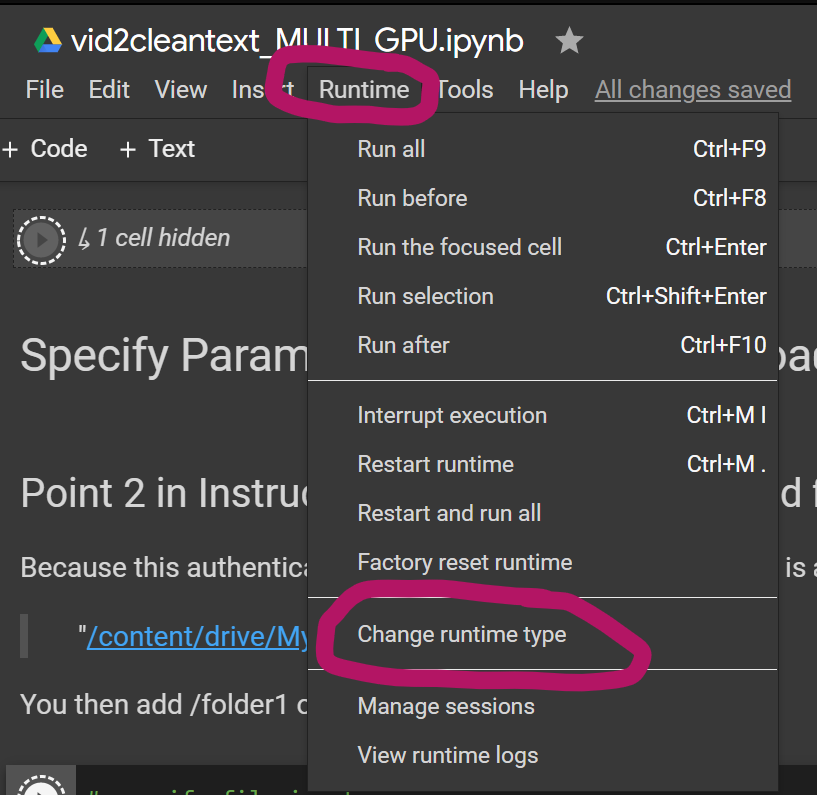

2. Change runtime to "high-ram" and to use a GPU as a hardware accelerator

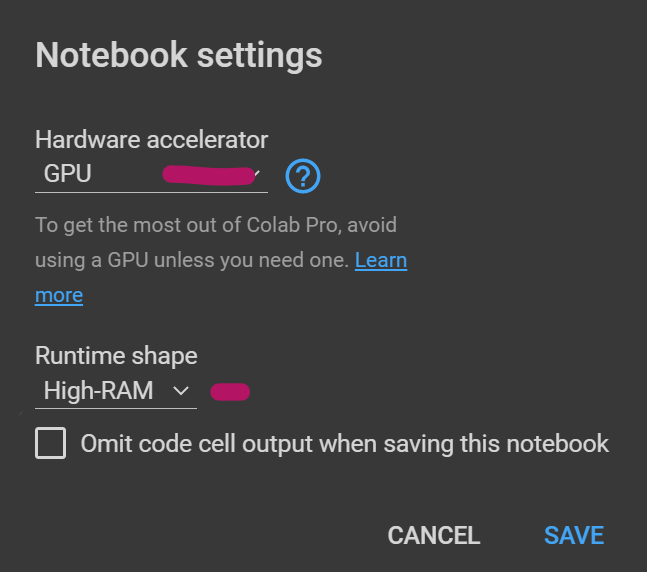

# Start of Code

## Mount Google Drive (#1)

### <font color="orange"> Point 1 in Instructions. 

**Note: for current code, the video file needs to be in google drive**

This part is relatively straightforward, as you run all the cells the file will stop here, ask you to authenticate your drive and give you a url. Do what it says.

In [ ]:
# create interface to upload / interact with google drive and video files
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')
# after you allow the authentication, you can work using the path "/content/drive/My Drive"
# if it works it will say "Mounted at /content/drive"

Mounted at /content/drive


## Specify filename and filepath (#2)

## <font color="orange"> Point 2 in Instructions

Because this notebook authenticates/connects to your drive, the "header" filepath is always the same as:

> "/content/drive/My Drive"

- You then add /folder1 or if multiple /folder1/folder2 etc

*NOTE you can also find the folder filepath by navigating in the Google Colab file browser (folder icon in the left menu on the screen)*

In [ ]:
directory = "/content/drive/MyDrive/Video/ETHZ2021s/example_vid_transc" #@param {type:"string"}
# set to false if you don't want it to download a zipped file of all the text
download_output_files = True #@param {type:"boolean"}
# specify file inputs

print('Will use the following as directory/file: ')
print(directory)

from datetime import datetime
run_start = datetime.now()
tag_date = "started_" + run_start.strftime("%m/%d/%Y, %H-%M")

Will use the following as directory/file: 
/content/drive/MyDrive/Video/ETHZ2021s/example_vid_transc


# Install, Import 

Notes on MoviePy releases are [on GitHub](https://github.com/Zulko/moviepy/releases). Sometimes issues arise when converting the video to audio

In [ ]:
%%capture
!pip install pysbd
!pip install -U transformers
!pip install wordninja
!pip install yake
!pip install symspellpy
!pip install pycuda
!pip install gputil
!pip install humanize
!pip install -U plotly
!pip install moviepy --pre --upgrade
!apt install ffmpeg
!pip install -U tqdm
!pip install -U neuspell
!pip install clean-text[gpl]

# !apt-get install ffmpeg

import math
import os
import pprint as pp
import shutil
import time
import re
from datetime import datetime
from os import listdir
from os.path import isfile, join

import librosa
import moviepy.editor as mp
import moviepy
import pandas as pd
import pkg_resources
import pysbd
import torch
import wordninja
import yake
from natsort import natsorted
from symspellpy import SymSpell
import transformers
from transformers import Wav2Vec2ForCTC, Wav2Vec2Tokenizer
import pycuda.driver as cuda
import psutil
import humanize
import os
import GPUtil as GPU
import neuspell
from tqdm.auto import tqdm
from cleantext import clean

# Function Definitions

## ipython display conf.

In [ ]:
%%capture
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

### generic functions 

In [ ]:
# define user functions 

def increase_font():
  from IPython.display import Javascript
  display(Javascript('''
  for (rule of document.styleSheets[0].cssRules){
    if (rule.selectorText=='body') {
      rule.style.fontSize = '24px'
      break
    }
  }
  '''))

def reset_font():
  from IPython.display import Javascript
  display(Javascript('''
  for (rule of document.styleSheets[0].cssRules){
    if (rule.selectorText=='body') {
      rule.style.fontSize = '14px'
      break
    }
  }
  '''))

def corr(s):
    # adds space after period if there isn't one
    # removes extra spaces
    return re.sub(r'\.(?! )', '. ', re.sub(r' +', ' ', s))

def cleantxt_wrap(ugly_text):
    # a wrapper for clean text with options different than default

    # https://pypi.org/project/clean-text/
    cleaned_text = clean(ugly_text,
                         fix_unicode=True,  # fix various unicode errors
                         to_ascii=True,  # transliterate to closest ASCII representation
                         lower=True,  # lowercase text
                         no_line_breaks=True,  # fully strip line breaks as opposed to only normalizing them
                         no_urls=True,  # replace all URLs with a special token
                         no_emails=True,  # replace all email addresses with a special token
                         no_phone_numbers=True,  # replace all phone numbers with a special token
                         no_numbers=False,  # replace all numbers with a special token
                         no_digits=False,  # replace all digits with a special token
                         no_currency_symbols=True,  # replace all currency symbols with a special token
                         no_punct=True,  # remove punctuations
                         replace_with_punct="",  # instead of removing punctuations you may replace them
                         replace_with_url="<URL>",
                         replace_with_email="<EMAIL>",
                         replace_with_phone_number="<PHONE>",
                         replace_with_number="<NUM>",
                         replace_with_digit="0",
                         replace_with_currency_symbol="<CUR>",
                         lang="en"  # set to 'de' for German special handling
                         )

    return cleaned_text


def beautify_filename(filename, num_words=20, start_reverse=False,
                      word_separator="_"):
    # takes a filename stored as text, removes extension, separates into X words ...
    # and returns a nice filename with the words separateed by
    # useful for when you are reading files, doing things to them, and making new files

    filename = str(filename)
    index_file_Ext = filename.rfind('.')
    current_name = str(filename)[:index_file_Ext]  # get rid of extension
    clean_name = cleantxt_wrap(current_name) # wrapper with custom defs
    file_words = wordninja.split(clean_name)
    # splits concatenated text into a list of words based on common word freq
    if len(file_words) <= num_words:
        num_words = len(file_words)

    if start_reverse:
        t_file_words = file_words[-num_words:]
    else:
        t_file_words = file_words[:num_words]

    pretty_name = word_separator.join(t_file_words)  # see function argument

    # NOTE IT DOES NOT RETURN THE EXTENSION
    return pretty_name[: (len(pretty_name) - 1)]  # there is a space always at the end, so -1


def quick_keys(filename, filepath, max_ngrams=3, num_keywords=20, save_db=False, 
               verbose=False):
    # uses YAKE to quickly determine keywords in a text file. Saves Keywords and YAKE score (0 means very important) in
    # an excel file (from a dataframe)
    # yes, the double entendre is intended.
    file = open(join(filepath, filename), 'r', encoding="utf-8", errors='ignore')
    text = file.read()
    file.close()

    language = "en"
    deduplication_threshold = 0.3  # technically a hyperparameter
    custom_kw_extractor = yake.KeywordExtractor(lan=language, n=max_ngrams, dedupLim=deduplication_threshold,
                                                top=num_keywords, features=None)
    yake_keywords = custom_kw_extractor.extract_keywords(text)
    phrase_db = pd.DataFrame(yake_keywords)
    if verbose:
        print("YAKE keywords are: \n", yake_keywords)
        print("dataframe looks like: \n")
        pp.pprint(phrase_db.head())

    if len(phrase_db) == 0:
        print("warning - no phrases were able to be extracted... ")
        return None 

    phrase_db.columns = ['key_phrase', 'YAKE_sore']

    # add a column for how many words the phrases contain
    yake_kw_len = []
    yake_kw_freq = []
    for entry in yake_keywords:
        entry_wordcount = len(str(entry).split(" ")) - 1
        yake_kw_len.append(entry_wordcount)

    for index, row in phrase_db.iterrows():
        search_term = row["key_phrase"]
        entry_freq = text.count(str(search_term))
        yake_kw_freq.append(entry_freq)

    word_len_series = pd.Series(yake_kw_len, name='No. Words in Phrase')
    word_freq_series = pd.Series(yake_kw_freq, name='Phrase Freq. in Text')
    phrase_db2 = pd.concat([phrase_db, word_len_series, word_freq_series], axis=1)
    # add column names and save file as excel because CSVs suck
    phrase_db2.columns = ['key_phrase', 'YAKE Score (Lower = More Important)', 'num_words', 'freq_in_text']

    if save_db:
        # saves individual file if user asks
        yake_fname = beautify_filename(filename=filename, start_reverse=False) + "_top_phrases_YAKE.xlsx"
        phrase_db2.to_excel(join(filepath, yake_fname), index=False)

    # print out top 10 keywords, or if desired num keywords less than 10, all of them
    max_no_disp = 10
    if num_keywords > max_no_disp:
        num_phrases_disp = max_no_disp
    else:
        num_phrases_disp = num_keywords

    if verbose:
        print("Top Key Phrases from YAKE, with max n-gram length: ", max_ngrams, "\n")
        pp.pprint(phrase_db2.head(n=num_phrases_disp))
    else:
        list_o_words = phrase_db2["key_phrase"].to_list()
        print("top 5 phrases are: \n")
        if len(list_o_words) < 5:
            pp.pprint(list_o_words)
        else:
            pp.pprint(list_o_words[:5])

    return phrase_db2



def digest_txt_directory(file_directory, identifer="", verbose=False,
                         make_folder=True):
    run_date = datetime.now()
    files_to_merge = natsorted([f for f in listdir(file_directory) if isfile(join(file_directory, f)) & f.endswith('.txt')])
    outfilename = 'Zealous_MERGED_words_' + identifer + run_date.strftime("_%d%m%Y_%H") + ".txt"

    og_wd = os.getcwd()
    os.chdir(file_directory)

    if make_folder:
        folder_name = "merged_txt_files"
        if not os.path.isdir(join(file_directory, folder_name)):
            os.mkdir(join(file_directory, folder_name))  # make a place to store outputs if one does not exist
        output_loc = join(file_directory, folder_name)

        outfilename = join(folder_name, outfilename)
        
        if verbose:
            print("created new folder. new full path is: \n", output_loc)

    count = 0
    with open(outfilename, 'w') as outfile:
    
        for names in files_to_merge:
    
            with open(names) as infile:
                count += 1
                outfile.write("Start of: " + names + '\n')
                outfile.writelines(infile.readlines())
    
            outfile.write("\n")

    print("Merged {} text files together.".format(count))
    if verbose:
        print("the merged file is located at: \n", os.getcwd())
    os.chdir(og_wd)


def validate_output_directories(directory, verbose=False):

    # checks and creates folders

    t_folder_name = "wav2vec2_sf_transcript"
    m_folder_name = "wav2vec2_sf_metadata"

    # check if transcription folder exists. If not, create it
    if not os.path.isdir(join(directory, t_folder_name)):
        os.mkdir(join(directory, t_folder_name))  # make a place to store outputs if one does not exist

        if verbose:
            print("needed to create the folder: {}. Its location is: \n".format(t_folder_name), join(directory, t_folder_name))
    t_path_full = join(directory, t_folder_name)

    # check if metadata folder exists. If not, create it
    if not os.path.isdir(join(directory, m_folder_name)):
        os.mkdir(join(directory, m_folder_name))  # make a place to store outputs if one does not exist

        if verbose:
            print("needed to create the folder: {}. Its location is: \n".format(m_folder_name), join(directory, m_folder_name))

    m_path_full = join(directory, m_folder_name)

    output_locs = {
        "t_out": t_path_full,
        "m_out": m_path_full
    }

    return output_locs


def move2completed(from_dir, filename, new_folder='completed', verbose=False):
    
    # this is the better version
    old_filepath = join(from_dir, filename)

    new_filedirectory = join(from_dir, new_folder)

    if not os.path.isdir(new_filedirectory):
        os.mkdir(new_filedirectory)
        if verbose:
            print("created new directory for files at: \n", new_filedirectory)

    new_filepath = join(new_filedirectory, filename)

    try:
        shutil.move(old_filepath, new_filepath)
        print("successfully moved the file {} to */completed.".format(filename))
    except:
        print("ERROR! unable to move file to \n{}. Please investigate".format(new_filepath))
        
print("loaded all generic functions at: ", datetime.now())

# create time log

time_log = []
time_log_desc = []
time_log.append(time.time())
time_log_desc.append("start")

loaded all generic functions at:  2021-07-13 01:37:06.688315


### time log

In [ ]:

def timelog_analytics(time_log, time_log_desc, save_path=None, show_plot=False, save_plot=True):
    # takes the two lists used everywhere in this file and makes a relatively useful report
    if save_path is None: save_path = os.getcwd()
    time_records_db = pd.DataFrame(list(zip(time_log_desc, time_log)), columns=['Event', 'Time (sec)'])
    start_time_block = time_records_db.loc[0, 'Time (sec)']
    time_records_db["time_mins"] = 0
    time_records_db["diff_time_mins"] = 0
    prior_time = 0
    for index, row in time_records_db.iterrows():
        normalized_time = row['Time (sec)'] - start_time_block
        time_records_db.loc[index, 'Time (sec)'] = normalized_time
        time_records_db.loc[index, 'time_mins'] = normalized_time / 60

        if prior_time == 0:
            time_records_db.loc[index, 'diff_time_mins'] = normalized_time / 60
            prior_time = normalized_time / 60
        else:
            # conditional check mostly for safety reasons
            time_records_db.loc[index, 'diff_time_mins'] = (normalized_time / 60) - prior_time
            prior_time = normalized_time / 60

    time_records_db.to_excel(join(save_path, "vid2cleantxt_" + datetime.now().strftime(
        "%d%m%Y") + "transc_time_log.xlsx"))
    print("total runtime was {} minutes".format(round((time_log[-1] - time_log[0]) / 60)))

    total_time = time_records_db["diff_time_mins"].sum()

    def get_time_frac(section_time):
        return section_time / total_time

    time_records_db["duration_frac"] = time_records_db["diff_time_mins"].apply(get_time_frac)
    time_records_db.loc[time_records_db['duration_frac'] < 0.03, 'Event'] = 'Misc.'  # Represent only large events
    figtitle = 'Run Time Viz - transc of {} video files on {}'.format(len(approved_files),
                                                                      datetime.now().strftime("%d.%m.%Y"))
    fig = px.pie(time_records_db, values='diff_time_mins', names='Event', 
                 title=figtitle, template='plotly_dark')
    if show_plot: fig.show()
    if save_plot: fig.to_html(join(save_path, "transcriptions {} run time viz.html".format(tag_date)),
                              include_plotlyjs=True, default_width=1280, default_height=720)



## check hardware


In [ ]:

    

def clear_GPU_cache(verbose=False):

    GPUs = GPU.getGPUs()

    if len(GPUs) > 0:
        check_runhardware_torch()
        torch.cuda.empty_cache()
        print("\nchecked and cleared cache")
    else:
        print("\nNo GPU being used :( time = ", datetime.now())
    if verbose:
        print("-----------End of Cache Clear----------------")

print("loaded all hardware functions at: ", datetime.now())


def check_runhardware_torch(verbose=False):
    # https://www.run.ai/guides/gpu-deep-learning/pytorch-gpu/

    GPUs = GPU.getGPUs()

    if len(GPUs) > 0:
        if verbose:
            print("\n ------------------------------")
            print("Checking CUDA status for PyTorch")

        torch.cuda.init()

        print("Cuda availability (PyTorch): ", torch.cuda.is_available())

        # Get Id of default device
        torch.cuda.current_device()
        if verbose:
            print("Name of GPU: ", torch.cuda.get_device_name(device=0))  # '0' is the id of your GPU
            print("------------------------------\n")
        return True

    else:
        print("No GPU being used :(")
        return False


def torch_validate_cuda(verbose=False):
    GPUs = GPU.getGPUs()
    num_gpus = len(GPUs)
    try:
        torch.cuda.init()
        if not torch.cuda.is_available():
            print("WARNING - CUDA is not being used in processing - expect longer runtime")
            if verbose: print("GPU util detects {} GPUs on your system".format(num_gpus))
    except:
        print("WARNING - unable to start CUDA. If you wanted to use a GPU, exit and check hardware.")


def check_runhardware(verbose=False):
    # ML package agnostic hardware check
    GPUs = GPU.getGPUs()

    if verbose:
        print("\n ------------------------------")
        print("Checking hardware with psutil")
    try:
        gpu = GPUs[0]
    except:
        if verbose: print("GPU not available - ", datetime.now())
        gpu = None
    process = psutil.Process(os.getpid())

    CPU_load = psutil.cpu_percent()
    if CPU_load > 0:
        cpu_load_string = "loaded at {} % |".format(CPU_load)
    else:
        # the first time process.cpu_percent() is called it returns 0 which can be confusing
        cpu_load_string = "|"
    print("\nGen RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available),
          " | Proc size: " + humanize.naturalsize(process.memory_info().rss),
          " | {} CPUs ".format(psutil.cpu_count()), cpu_load_string)

    if len(GPUs) > 0 and GPUs is not None:
        print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB\n".format(gpu.memoryFree,
                                                                                                      gpu.memoryUsed,
                                                                                                      gpu.memoryUtil * 100,
                                                                                                      gpu.memoryTotal))
    else:
        print("No GPU being used :(", "\n-----------------\n")



def only_clear_GPU_cache(verbose=False):

    GPUs = GPU.getGPUs()

    if len(GPUs) > 0:
        torch.cuda.empty_cache()
        if verbose:
            print("\nchecked and cleared cache")
    else:
        print("\nClearCache - No GPU being used :( time = ", datetime.now())
        
# create time log

time_log.append(time.time())
time_log_desc.append("loaded hardware functions")

loaded all hardware functions at:  2021-07-13 01:37:06.798367


## spell correction

In [ ]:
%%capture
# neuspell prints out the whole upon definition, hence ^ jupyter magic

def symspell_file(filepath, filename, dist=2, keep_numb_words=True, create_folder=True, save_metrics=False,
                  verbose=False):
    # given a text (has to be text) file, reads the file, autocorrects any words it deems misspelled, saves as new file
    # it can store the new file in a sub-folder it creates as needed
    # distance represents how far it searches for a better spelling. higher dist = higher RT.
    # https://github.com/mammothb/symspellpy

    script_start_time = time.time()
    sym_spell = SymSpell(max_dictionary_edit_distance=dist, prefix_length=7)
    print("\nPySymSpell - Starting to correct the file: ", filename)
    # ------------------------------------

    dictionary_path = pkg_resources.resource_filename(
        "symspellpy", "frequency_dictionary_en_82_765.txt")
    bigram_path = pkg_resources.resource_filename(
        "symspellpy", "frequency_bigramdictionary_en_243_342.txt")
    # term_index is the column of the term and count_index is the
    # column of the term frequency
    sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
    sym_spell.load_bigram_dictionary(bigram_path, term_index=0, count_index=2)

    # ------------------------------------
    file = open(join(filepath, filename), 'r', encoding="utf-8", errors='ignore')
    textlines = file.readlines()  # return a list
    file.close()

    if create_folder:
        # create a folder
        output_folder_name = "auto-corrected" 
        if not os.path.isdir(join(filepath, output_folder_name)):
            os.mkdir(join(filepath, output_folder_name))  # make a place to store outputs if one does not exist
        filepath = join(filepath, output_folder_name)

    if verbose:
        print("loaded text with {0:6d} lines ".format(len(textlines)))

    corrected_list = []

    # iterate through list of lines. Pass each line to be corrected. 
    #Append / sum results from each line till done
    for line in textlines:
        if line == "":
            # blank line, skip to next run
            continue

        # correct the line of text using spellcorrect_line() which returns a dictionary
        suggestions = sym_spell.lookup_compound(phrase=line, max_edit_distance=dist, 
                                                ignore_non_words=keep_numb_words,
                                                ignore_term_with_digits=keep_numb_words)
        all_sugg_for_line = []
        for suggestion in suggestions:
            all_sugg_for_line.append(suggestion.term)

        # append / sum / log results from correcting the line

        corrected_list.append(' '.join(all_sugg_for_line) + "\n")

    # finished iterating through lines. Now sum total metrics

    corrected_doc = "".join(corrected_list)
    corrected_fname = "Corrected_SSP_" + beautify_filename(filename, 
                                                           num_words=10, start_reverse=False) + ".txt"

    # proceed to saving
    file_out = open(join(filepath, corrected_fname), 'w',
                    encoding="utf-8", errors='ignore')
    file_out.writelines(corrected_doc)
    file_out.close()

    # report RT
    if verbose:
        script_rt_m = (time.time() - script_start_time) / 60
        print("RT for this file was {0:5f} minutes".format(script_rt_m))
        print("output folder for this transcription is: \n", 
              filepath)

    print("Done correcting ", filename, " at time: ", 
          datetime.now().strftime("%H:%M:%S"), "\n")

    corr_file_Data = {
        "corrected_ssp_text": corrected_doc,
        "corrected_ssp_fname": corrected_fname,
        "output_path": filepath,
    }
    return corr_file_Data


# preload defaults
sym_spell = SymSpell(max_dictionary_edit_distance=3, prefix_length=7)

dictionary_path = pkg_resources.resource_filename(
        "symspellpy", "frequency_dictionary_en_82_765.txt")
bigram_path = pkg_resources.resource_filename(
        "symspellpy", "frequency_bigramdictionary_en_243_342.txt")
# term_index is the column of the term and count_index is the
# column of the term frequency
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
sym_spell.load_bigram_dictionary(bigram_path, term_index=0, count_index=2)

print("loaded defaults - ", datetime.now())

def symspell_freetext(textlines, dist=3, keep_numb_words=True, verbose=False,
                      d_path=dictionary_path, b_path=bigram_path, default=sym_spell):
    # https://github.com/mammothb/symspellpy

    if dist != 3:

        # have to recreate object each time because doesn't match pre-built

        sym_spell = SymSpell(max_dictionary_edit_distance=dist, prefix_length=7)
        sym_spell.load_dictionary(d_path, term_index=0, count_index=1)
        sym_spell.load_bigram_dictionary(b_path, term_index=0, count_index=2)
    else:
        sym_spell=default

    corrected_list = []

    if type(textlines) == str:
        textlines = [textlines] # put in a list if a string

    if verbose:
        print("\nStarting to correct text with {0:6d} lines ".format(len(textlines)))
        print("the type of textlines var is ",type(textlines))

    # iterate through list of lines. Pass each line to be corrected. Append / sum results from each line till done
    for line_obj in textlines:
        line = ''.join(line_obj) 
        if verbose:
            print("line {} in the text is: ".format(textlines.index(line_obj)))
            pp.pprint(line) 
        if line == "":
            # blank line, skip to next run
            continue

        suggestions = sym_spell.lookup_compound(phrase=line, max_edit_distance=dist, 
                                                ignore_non_words=keep_numb_words,
                                                ignore_term_with_digits=keep_numb_words)
        all_sugg_for_line = []
        for suggestion in suggestions:
            all_sugg_for_line.append(suggestion.term)

        # append / sum / log results from correcting the line

        corrected_list.append(' '.join(all_sugg_for_line) + "\n")

    # join corrected text

    corrected_text = "".join(corrected_list)

    if verbose:
        print("Finished correcting w/ symspell at time: ", datetime.now(), "\n")

    return corrected_text


# START OF NEUSPELL

checker = neuspell.SclstmbertChecker()
checker.from_pretrained()

def neuspell_freetext(textlines, verbose=False):

    corrected_list = []

    if type(textlines) == str:
        textlines = [textlines] # put in a list if a string

    # iterate through list of lines. Pass each line to be corrected. Append / sum results from each line till done
    for line_obj in textlines:
        line = ''.join(line_obj) 

        if verbose:
            print("line {} in the text is: ".format(textlines.index(line_obj)))
            pp.pprint(line) 
        if line == "" or (len(line) <= 5):
            # blank line, skip to next run
            continue

        line = line.lower()
        corrected_text = checker.correct_strings([line])
        corrected_text_f = " ".join(corrected_text)

        corrected_list.append(corrected_text_f + "\n")

    # join corrected text

    corrected_text = " ".join(corrected_list)

    if verbose:
        print("Finished correcting w/ neuspell at time: ", datetime.now(), "\n")

    return corrected_text

def SBD_freetext(text, verbose=False):
    # input should be STRING
    # use pysbd to segment 

    if isinstance(text, list):
        print("Warning, input ~text~ has type {}. Will convert to str".format(type(text)))
        text = " ".join(text)

    seg = pysbd.Segmenter(language="en", clean=True)
    sentences = []
    sentences = seg.segment(text)

    if verbose:
        print("input text of {} words was split into ".format(len(text.split(" "))),
              len(sentences), "sentences")

    # take segments and make them sentences
    
    capitalized = []
    for sentence in sentences:
        if sentence and sentence.strip():
            # ensure that the line is not all spaces
            first_letter = sentence[0].upper()
            rest = sentence[1:]
            capitalized.append(first_letter + rest)

    seg_and_capital = ". ".join(capitalized)

    return seg_and_capital

print("loaded all spell correction functions at: ", datetime.now())



### spell-correction pipeline

In [ ]:
def spellcorrect_pipeline(filepath, filename, verbose=False):
    # uses two functions (neuspell_freetext, SBD_freetext)
    # in a pipeline

    file = open(join(filepath, filename), 'r', encoding="utf-8", errors='ignore')
    textlines = file.readlines()  # return a list
    file.close()

    sc_textlines = neuspell_freetext(textlines, verbose=verbose)

    loc_SC = "neuspell_sc"
    if not os.path.isdir(join(filepath, loc_SC)):
        os.mkdir(join(filepath, loc_SC))  # make a place to store outputs if one does not exist

    sc_outname = "NSC_" + beautify_filename(filename, 
                                           num_words=15, 
                                           start_reverse=False) + ".txt"
    
    file_sc = open(join(filepath, loc_SC, sc_outname), 'w', 
                   encoding="utf-8", errors='replace')
    file_sc.writelines(sc_textlines)
    file_sc.close()
    quick_sc_fixes = {
                " ' ": "'",
                    }
    if isinstance(sc_textlines, list):
        SBD_sc_textlines = []
        for line in sc_textlines:
            if isinstance(line, list):
                # handles weird corner cases
                line = " ".join(line)

            sentenced = SBD_freetext(line, verbose=verbose)
            for key, value in quick_sc_fixes.items():

                sentenced = sentenced.replace(key, value)

            SBD_sc_textlines.append(sentenced)
    else:
        SBD_sc_textlines = SBD_freetext(sc_textlines, verbose=verbose)

        for key, value in quick_sc_fixes.items():

            SBD_sc_textlines = SBD_sc_textlines.replace(key, value)

    # SBD_text = " ".join(SBD_sc_textlines)

    loc_SBD = "NSC + SBD"
    if not os.path.isdir(join(filepath, loc_SBD)):
        os.mkdir(join(filepath, loc_SBD))  # make a place to store outputs if one does not exist
    
    SBD_outname = "FIN_" + beautify_filename(filename, 
                                               num_words=15, 
                                               start_reverse=False) + ".txt"
    
    file_sc = open(join(filepath, loc_SBD, SBD_outname), 'w', 
                   encoding="utf-8", errors='replace')
    file_sc.writelines(SBD_sc_textlines)
    file_sc.close()

    pipelineout = {
        "original_transcript_text": " ".join(textlines),
        "spellcorrected_text": " ".join(sc_textlines),
        "final_text": " ".join(SBD_sc_textlines),
        "spell_corrected_dir": join(filepath, loc_SC),
        "sc_filename":sc_outname,
        "SBD_dir": join(filepath, loc_SBD),
        "SBD_filename":SBD_outname
    }

    return pipelineout

print("loaded spell correction pipeline at: ", datetime.now())

loaded spell correction pipeline at:  2021-07-13 01:38:04.491563


## vid2cleantext specific

things that are more or less unique to video conversion / audio transcription.

In [ ]:
def convert_vidfile(vidfilename, start_time=0, end_time=6969, 
                    input_directory="", output_directory="", new_filename=""):
    # takes a video file and creates an audiofile with various parameters
    # NOTE video filename is required
    if len(input_directory) < 1:
        my_clip = mp.VideoFileClip(vidfilename)
    else:
        my_clip = mp.VideoFileClip(join(input_directory, vidfilename))

    if end_time == 6969:
        modified_clip = my_clip.subclip(t_start=int(start_time * 60))
    else:
        modified_clip = my_clip.subclip(t_start=int(start_time * 60), t_end=int(end_time * 60))

    converted_filename = vidfilename[: (len(vidfilename) - 4)] + "-converted_" + \
                         datetime.now().strftime("day_%d_time_%H-%M-%S_") + ".wav"
    # update_filename
    if len(new_filename) > 0:
        converted_filename = new_filename

    if len(output_directory) < 1:
        modified_clip.audio.write_audiofile(converted_filename)
    else:
        # removed 'verbose=False,' from argument of function (removed from Dev)
        modified_clip.audio.write_audiofile(join(output_directory, converted_filename), logger=None)

    audio_conv_results = {
        "output_filename": converted_filename,
        "output_folder": output_directory,
        "clip_length": modified_clip.duration
    }

    return audio_conv_results


def convert_vid_for_transcription(vid2beconv, len_chunks, input_directory, 
                                  output_directory):
    # Oriented specifically for the "wav2vec2" model speech to text transcription
    # takes a video file, turns it into .wav audio chunks of length <input> and stores them in a specific location
    # TODO add try/except clause in case the user already has an audio file the want to transcribe
    my_clip = mp.VideoFileClip(join(input_directory, vid2beconv))
    number_of_chunks = math.ceil(my_clip.duration / len_chunks)  # to get in minutes
    print('converting into ' + str(number_of_chunks) + ' audio chunks')
    preamble = beautify_filename(vid2beconv)
    outfilename_storage = []
    print('separating audio into chunks starting at ', datetime.now().strftime("_%H.%M.%S"))
    update_incr = math.ceil(number_of_chunks / 10)

    for i in tqdm(range(number_of_chunks), desc="Converting Video to Audio Chunks",
                  total=number_of_chunks):

        start_time = i * len_chunks
        if i == number_of_chunks - 1:
            this_clip = my_clip.subclip(t_start=start_time)
        else:
            this_clip = my_clip.subclip(t_start=start_time, t_end=(start_time + len_chunks))
        this_filename = preamble + '_run_' + str(i) + '.wav'
        outfilename_storage.append(this_filename)

        if(this_clip.audio is not None):
        # removed 'verbose=False,' from argument of function (removed from Dev)
            this_clip.audio.write_audiofile(join(output_directory, this_filename), logger=None)
        else:
            print("\n WARNING: chunk {} is empty / has no audio".format(i))

    print('Finished creating audio chunks at ', datetime.now().strftime("_%H.%M.%S"))
    print('Files are located in ', output_directory)
    return outfilename_storage



def transcribe_video_wav2vec(transcription_model, directory, vid_clip_name, 
                             chunk_length_seconds):
    # this is the same process as used in the single video transcription, now as a function. Note that spell correction
    # and keyword extraction are now done separately in the script
    # user needs to pass in: the model, the folder the video is in, and the name of the video
    output_path_full = directory

    # Split Video into Audio Chunks-----------------------------------------------

    print("\n============================================================")
    print("Converting video to audio for file: ", vid_clip_name)
    print("============================================================\n")

    # create audio chunk folder
    output_folder_name = "audio_chunks"
    if not os.path.isdir(join(directory, output_folder_name)):
        os.mkdir(join(directory, output_folder_name))  # make a place to store outputs if one does not exist
    path2audiochunks = join(directory, output_folder_name)
    chunk_directory = convert_vid_for_transcription(vid2beconv=vid_clip_name, input_directory=directory,
                                                    len_chunks=chunk_length_seconds, output_directory=path2audiochunks)

    print("\n============================================================")
    print("converted video to audio. About to start transcription loop for file: ", vid_clip_name)
    print("============================================================\n")
    torch_validate_cuda()
    check_runhardware()
    time_log.append(time.time())
    time_log_desc.append("converted video to audio")
    full_transcription = []
    before_loop_st = time.time()
    GPU_update_incr = math.ceil(len(chunk_directory) / 2)

    # Load audio chunks by name, pass into model, append output text-----------------------------------------------
    
    for audio_chunk in tqdm(chunk_directory, total=len(chunk_directory),
                                    desc="wav2vec2 model for "+vid_clip_name):

        current_loc = chunk_directory.index(audio_chunk)
        if (current_loc % GPU_update_incr == 0) and (GPU_update_incr != 0):
            # provide update on GPU usage
            check_runhardware()
            
        # load dat chunk
        audio_input, rate = librosa.load(join(path2audiochunks, audio_chunk), sr=16000)
        # MODEL 
        device = "cuda:0" if torch.cuda.is_available() else "cpu"
        input_values = tokenizer(audio_input, return_tensors="pt", padding="longest", truncation=True).input_values.to(device)
        transcription_model = transcription_model.to(device)
        logits = transcription_model(input_values).logits
        predicted_ids = torch.argmax(logits, dim=-1)
        transcription = str(tokenizer.batch_decode(predicted_ids)[0])
        full_transcription.append(transcription + "\n")
        # empty memory so you don't overload the GPU
        del input_values
        del logits
        del predicted_ids
        del audio_input
        torch.cuda.empty_cache()


    print("\nFinished audio transcription of " + vid_clip_name + " and now saving metrics.")

    # build metadata log -------------------------------------------------
    mdata = []
    mdata.append('original file name: ' + vid_clip_name + '\n')
    mdata.append(
        'number of recorded audio chunks: ' + str(len(chunk_directory)) + " of lengths seconds each" + str(
            chunk_length_seconds) + '\n')
    approx_input_len = (len(chunk_directory) * chunk_length_seconds) / 60
    mdata.append('approx {0:3f}'.format(approx_input_len) + ' minutes of input audio \n')
    mdata.append('transcription date: ' + datetime.now().strftime("date_%d_%m_%Y_time_%H-%M-%S") + '\n')
    full_text = ' '.join(full_transcription)
    transcript_length = len(full_text)
    mdata.append("length of transcribed text: " + str(transcript_length) + ' characters \n')
    t_word_count = len(full_text.split(' '))
    mdata.append("total word count: " + str(t_word_count) + ' words (based on spaces) \n')

    # delete audio chunks in folder -------------------------------------------------
    # TODO add try/except for deleting folder as not technically needed to achieve goal
    shutil.rmtree(path2audiochunks)
    print("\nDeleted Audio Chunk Folder + Files")

    # compile results -------------------------------------------------
    transcription_results = {
        "audio_transcription": full_transcription,
        "metadata": mdata
    }

    print("\nFinished transcription successfully for " + vid_clip_name + " at "
          + datetime.now().strftime("date_%d_%m_%Y_time_%H-%M-%S"))
    return transcription_results

print("loaded all transcription specific functions at: ", datetime.now())


loaded all transcription specific functions at:  2021-07-13 01:38:04.730044


# Specify Parameters, File Locations, Load wav2vec2 Model

## load video files

In [ ]:

# iterate through and grab files:

files_to_munch = natsorted([f for f in listdir(directory) if isfile(os.path.join(directory, f))])
total_files_1 = len(files_to_munch)
removed_count_1 = 0
approved_files = []
# remove non-video files
for prefile in files_to_munch:
    if prefile.endswith(".mp4") or prefile.endswith(".mov") \
    or prefile.endswith(".avi") or prefile.endswith(".mkv"):
        approved_files.append(prefile)
    else:
        files_to_munch.remove(prefile)
        removed_count_1 += 1

print("out of {0:3d} file(s) originally in the folder, ".format(total_files_1),
      "{0:3d} non-video files were removed".format(removed_count_1))
print('\n {0:3d} video file(s) in folder will be transcribed.'.format(len(approved_files)))

pp.pprint(approved_files)


out of   1 file(s) originally in the folder,    0 non-video files were removed

   1 video file(s) in folder will be transcribed.
['Cassini Hackathon - Overview of Local Challenges.mp4']


## Load wav2vec2 model (#3)

### <font color="orange"> Point 3 in Instructions: Update chunk_length

Update the variable 'chunk_length' to your use case. A good value is one that doesn't cause Colab to crash and is greater than a sentence length (for context, grammar purposes).


30 seconds works well 


In [ ]:
chunk_length = 30 #@param {type:"integer"}


In [ ]:
from transformers import Wav2Vec2ForMaskedLM, Wav2Vec2CTCTokenizer

# load huggingface model
# note to self: directory paths are: path "/content/drive/My Drive"
time_log.append(time.time())
time_log_desc.append("starting to load model")

# load pretrained model
wav2vec2_model = "facebook/wav2vec2-large-960h-lv60-self" 
# wav2vec2_model = "facebook/wav2vec2-large" 
# wav2vec2_model = "facebook/wav2vec2-base-960h" # faster+smaller, less accurate
print("\nPreparing to load model: " + wav2vec2_model)
tokenizer = Wav2Vec2Tokenizer.from_pretrained(wav2vec2_model)
# Need to switch ^ eventually due to:
# Please use `Wav2Vec2Processor` or `Wav2Vec2CTCTokenizer` instead.
model = Wav2Vec2ForCTC.from_pretrained(wav2vec2_model)
# model = Wav2Vec2ForCTC.from_pretrained(wav2vec2_model)
# (in seconds) if model fails to work or errors out (and there isn't some other
# obvious error, reduce this number. 30 is a good start.


print("loaded the following model:", wav2vec2_model, " at ", datetime.now())
time_log.append(time.time())
time_log_desc.append("loaded model")


Preparing to load model: facebook/wav2vec2-large-960h-lv60-self


Downloading:   0%|          | 0.00/291 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/162 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/wav2vec2/tokenization_wav2vec2.py:419: FutureWarning: The class `Wav2Vec2Tokenizer` is deprecated and will be removed in version 5 of Transformers. Please use `Wav2Vec2Processor` or `Wav2Vec2CTCTokenizer` instead.
  FutureWarning,


Downloading:   0%|          | 0.00/1.61k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

loaded the following model: facebook/wav2vec2-large-960h-lv60-self  at  2021-07-13 01:38:43.034399


---

# Run Transformers Model (wav2vec2)

In [ ]:
import gc
gc.collect()
check_runhardware()


Gen RAM Free: 24.5 GB  | Proc size: 5.7 GB  | 4 CPUs  loaded at 19.6 % |
GPU RAM Free: 16278MB | Used: 2MB | Util   0% | Total 16280MB



In [ ]:

# load videos, run through the model
t_script_start_time = time.time()
time_log.append(t_script_start_time)
time_log_desc.append("starting transcription process")

# iterate through list of video files, transcribing one at a time --------------------------------------------------
for filename in tqdm(approved_files, total=len(approved_files), 
                     desc="Overall Transcription Progress"):
    
    filename_p = beautify_filename(filename, start_reverse=False, num_words=10)

    t_script_start_time = time.time()
    time_log.append(t_script_start_time)
    time_log_desc.append("starting transcription process for " + filename)
    # transcribe the video file
    t_results = transcribe_video_wav2vec(transcription_model=model, directory=directory,
                                         vid_clip_name=filename, chunk_length_seconds=chunk_length)
    # t_results is a dictonary containing the transcript and associated metadata
    full_transcription = t_results.get('audio_transcription')
    metadata = t_results.get('metadata')
    # check if directories for output exist. If not, create them
    storage_locs = validate_output_directories(directory)
    output_path_transcript = storage_locs.get('t_out')
    output_path_metadata = storage_locs.get('m_out')

    # label and store this transcription
    vid_preamble = beautify_filename(filename, num_words=30, start_reverse=False)  # gets a nice phrase from filename
    # transcription
    ID = str(1 + approved_files.index(filename))
    transcribed_filename = vid_preamble + '_transcription_' + ID + '.txt'
    transcribed_file = open(os.path.join(output_path_transcript, transcribed_filename), 'w', encoding="utf-8", errors='ignore')
    transcribed_file.writelines(full_transcription)
    transcribed_file.close()
    # metadata
    metadata_filename = 'metadata - ' + vid_preamble + '_transcription_' + ID + '.txt'
    metadata_file = open(os.path.join(output_path_metadata, metadata_filename), 'w', encoding="utf-8", errors='ignore')
    metadata_file.writelines(metadata)
    metadata_file.close()

    print("{:3d}".format(files_to_munch.index(filename) + 1), " of {:3d} total files done".format(len(files_to_munch)))
    t_script_end_time = time.time()
    time_log.append(t_script_end_time)
    time_log_desc.append("transc. file #{}".format(ID) + filename[:5] + "...")

    this_rt = (t_script_end_time - t_script_start_time) / 60
    print("completed transcription in {} minutes".format(this_rt))

    move2completed(directory, filename=filename)

    # save runtime database after each run
    time_records_db = pd.DataFrame(list(zip(time_log_desc, time_log)), columns=['Event', 'Time (sec)'])
    time_records_db.to_excel(os.path.join(output_path_metadata, "mid_loop_runtime_database.xlsx"))

time_log.append(time.time())
time_log_desc.append("all transcriptions completed")

print("\n----------------------------")
print("transcription process completed - ", datetime.now())


Overall Transcription Progress:   0%|          | 0/1 [00:00<?, ?it/s]


Converting video to audio for file:  Cassini Hackathon - Overview of Local Challenges.mp4

converting into 36 audio chunks
separating audio into chunks starting at  _01.38.44


Converting Video to Audio Chunks:   0%|          | 0/36 [00:00<?, ?it/s]

Finished creating audio chunks at  _01.39.20
Files are located in  /content/drive/MyDrive/Video/ETHZ2021s/example_vid_transc/audio_chunks

converted video to audio. About to start transcription loop for file:  Cassini Hackathon - Overview of Local Challenges.mp4


Gen RAM Free: 24.5 GB  | Proc size: 5.7 GB  | 4 CPUs  loaded at 30.3 % |
GPU RAM Free: 16278MB | Used: 2MB | Util   0% | Total 16280MB



wav2vec2 model for Cassini Hackathon - Overview of Local Challenges.mp4:   0%|          | 0/36 [00:00<?, ?it/s…


Gen RAM Free: 24.5 GB  | Proc size: 5.7 GB  | 4 CPUs  loaded at 40.4 % |
GPU RAM Free: 16278MB | Used: 2MB | Util   0% | Total 16280MB


Gen RAM Free: 24.3 GB  | Proc size: 6.4 GB  | 4 CPUs  loaded at 24.8 % |
GPU RAM Free: 14113MB | Used: 2167MB | Util  13% | Total 16280MB


Finished audio transcription of Cassini Hackathon - Overview of Local Challenges.mp4 and now saving metrics.

Deleted Audio Chunk Folder + Files

Finished transcription successfully for Cassini Hackathon - Overview of Local Challenges.mp4 at date_13_07_2021_time_01-40-37
  1  of   1 total files done
completed transcription in 1.8962457021077475 minutes
successfully moved the file Cassini Hackathon - Overview of Local Challenges.mp4 to */completed.

----------------------------
transcription process completed -  2021-07-13 01:40:38.126116


# Post Model: Save files, Spell Check, SBD, Keywords

If you got to here, your colab file was able to run the model and transcribe it. Now a little cleaning up, then done.

### Merge Files


```digest_txt_directory(file_directory, identifer="", verbose=False, make_folder=False)```

In [ ]:
merge_transc = True #@param {type:"boolean"}


In [ ]:
# ----------------------------------- Merge transcription Files  -------------------------------
# makes things easier to review when you only have to open one file instead of N
locations = validate_output_directories(directory, verbose=True)
output_path_transcript = locations.get('t_out')
output_path_metadata = locations.get('m_out')
 
if merge_transc:
    time_log.append(time.time())
    time_log_desc.append("Merging Transcriptions")

    pr_time = datetime.now().strftime("date_%d_%m_%Y_time_%H")
    print("Creating merged files from original transcriptions")
    digest_txt_directory(output_path_transcript, identifer="original_tscripts" + pr_time)
    digest_txt_directory(output_path_metadata, identifer="ALLE_metadata_for_tscript_run" + pr_time,
                   make_folder=False)

    time_log.append(time.time())
    time_log_desc.append("Finished Merging Transcriptions")
else:
    print("the value of merge_transc is set to ", merge_transc)
    increase_font()

Creating merged files from original transcriptions
Merged 2 text files together.
Merged 2 text files together.


### Validate text files to spell-check

In [ ]:
# first, you need to go through the output directory of transcripts and make sure that all those files are gucci
transcripts_to_munch = natsorted(
    [f for f in listdir(output_path_transcript) if isfile(os.path.join(output_path_transcript, f))])
t_files = len(transcripts_to_munch)
removed_count_t = 0
approved_txt_files=[]
# remove non-.txt files
for tfile in transcripts_to_munch:
    if tfile.endswith(".txt"):
        approved_txt_files.append(tfile)
    else:
        transcripts_to_munch.remove(tfile)
        removed_count_t += 1

print("out of {0:3d} file(s) originally in the folder, ".format(t_files),
      "{0:3d} non-txt files were removed".format(removed_count_t))


out of   2 file(s) originally in the folder,    0 non-txt files were removed


## Spellcorrect Pipeline

In [ ]:
transcript_run_qk = pd.DataFrame() # empty df to hold all the keywords

for orig_tscript in tqdm(approved_txt_files, total=len(approved_txt_files), 
                                desc="spellcorrect_pipeline on transcriptions"):

    current_loc = approved_txt_files.index(orig_tscript) + 1 # add 1 bc start at 0
    print("\nStarting file {} of ".format(current_loc), len(approved_txt_files),
          " | ", orig_tscript)

    PL_out = spellcorrect_pipeline(output_path_transcript, orig_tscript, 
                                   verbose=False) # verbose is just for debug
    directory_for_keywords = PL_out.get("spell_corrected_dir")
    filename_for_keywords = PL_out.get("sc_filename")
    
    qk_df = quick_keys(filepath=directory_for_keywords, filename=filename_for_keywords,
                            num_keywords=25, max_ngrams=3, save_db=False, verbose=False)
    
    print("completed keywords")
    transcript_run_qk = pd.concat([transcript_run_qk, qk_df], axis=1)

# save overall transcription file 
keyword_db_name = "YAKE - keywords for all transcripts in run.csv"
transcript_run_qk.to_csv(join(output_path_transcript, keyword_db_name), index=True)

print("Transcription files used to extract KW can be found in: \n ", directory_for_keywords)
print("A file with keyword results is in {} \ntitled {}".format(output_path_transcript, keyword_db_name))

time_log.append(time.time())
time_log_desc.append("SC, keywords")

spellcorrect_pipeline on transcriptions:   0%|          | 0/2 [00:00<?, ?it/s]


Starting file 1 of  2  |  cassini_hack_a_th_on_overview_of_local_challenge_transcription_1.txt
top 5 phrases are: 

['team green spaces',
 'house space data',
 'encourage mixed teams',
 'open data swiss',
 'make dedicated channels']
completed keywords

Starting file 2 of  2  |  cassini_swiss_intro_session_showing_data_acces_transcription_1.txt
top 5 phrases are: 

['swiss data cube',
 'wanted pollution data',
 'area of interest',
 'central time lends',
 'local product collections']
completed keywords
Transcription files used to extract KW can be found in: 
  /content/drive/MyDrive/Video/ETHZ2021s/example_vid_transc/wav2vec2_sf_transcript/neuspell_sc
A file with keyword results is in /content/drive/MyDrive/Video/ETHZ2021s/example_vid_transc/wav2vec2_sf_transcript 
titled YAKE - keywords for all transcripts in run.csv


# Save, Download, Exit


## Download All Files in .zip


In [ ]:
import os, shutil
from os.path import basename
zip_dir = join(directory, "zipped_outputs")
os.makedirs(zip_dir, exist_ok=True)
transc_header = "vid2clntxt_transcripts_archive" + datetime.now().strftime("%d%m%Y")
shutil.make_archive(join(zip_dir, transc_header), "zip", output_path_transcript)
meta_header = "vid2clntxt_metadata_archive" + datetime.now().strftime("%d%m%Y")
shutil.make_archive(join(zip_dir, meta_header), "zip", output_path_metadata)

if download_output_files:
    files.download(join(zip_dir, transc_header + ".zip"))
    files.download(join(zip_dir, meta_header + ".zip"))
    print("downloaded files - ", datetime.now())
else:
    print("download_output_files is set to: ", download_output_files)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

downloaded files -  2021-07-13 01:46:36.261228


# Exit block

In [ ]:
print("\n\n----------------------------------- Script Complete -------------------------------")
print(datetime.now())
print("Transcription files + more in folder: \n", output_path_transcript)
print("More specifically, best transcriptions in: \n", PL_out.get("SBD_dir"))
print("Metadata for each transcription located @ \n", output_path_metadata)
time_log.append(time.time())
time_log_desc.append("End")



----------------------------------- Script Complete -------------------------------
2021-07-13 01:46:02.566533
Transcription files + more in folder: 
 /content/drive/MyDrive/Video/ETHZ2021s/example_vid_transc/wav2vec2_sf_transcript
More specifically, best transcriptions in: 
 /content/drive/MyDrive/Video/ETHZ2021s/example_vid_transc/wav2vec2_sf_transcript/NSC + SBD
Metadata for each transcription located @ 
 /content/drive/MyDrive/Video/ETHZ2021s/example_vid_transc/wav2vec2_sf_metadata


## runtime analysis 

Viz time records

In [ ]:
import plotly.express as px
timelog_analytics(time_log, time_log_desc, save_path=output_path_metadata, 
                  show_plot=True, save_plot=True)


total runtime was 9 minutes
